# Problems

In [10]:
import sys
sys.path.append('waveglow/')

import numpy as np
import torch
import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline

from hparams import create_hparams
from model import Tacotron2
from train import load_model, load_checkpoint
from text import text_to_sequence, sequence_to_text
from audio_processing import griffin_lim
from layers import TacotronSTFT

In [11]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

In [12]:
hparams = create_hparams()

## Load model from training checkpoint

In [13]:
# tacotron2
iteration = 'last_'
checkpoint_path = './training-remarks/t2s-008/checkpoint_{}'.format(iteration)
model = load_model(hparams)
model, _, _, _ = load_checkpoint(checkpoint_path, model)
_ = model.cuda().eval().half()

Loading checkpoint './training-remarks/t2s-008/checkpoint_last_'
Loaded checkpoint './training-remarks/t2s-008/checkpoint_last_' from iteration 395000


In [14]:
# waveglow
waveglow_path = './pretrain_model/waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']
_ = waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()

## Prepare text input

In [24]:
text = "香港仔去淺水灣"
sequence = np.array(text_to_sequence(text, ['cantonese_cleaners']))[None, :]
sequence = torch.autograd.Variable(torch.from_numpy(sequence).cuda().long())


In [25]:
sequence_to_text(sequence.data.cpu().numpy()[0])

'hoeng1 gong2 zi2 heoi3 cin2 seoi2 waan1'

## Synthesize audio from spectrogram

In [17]:
# load test data
from data_utils import TextMelLoader
from text import sequence_to_text

In [18]:
test_path = '/home/lokhiufung/data/cantonese/training/synthetic_data/dev_tacotron2.txt'
text_mel_loader = TextMelLoader(test_path, hparams)
sequence, mel = text_mel_loader[0]
print(sequence_to_text(sequence.data.cpu().numpy()))
sequence = sequence.unsqueeze(0).cuda().long()
# text = sequence_to_text(sequence)  # convert a sequence of IDs back to a string

hai2 wu6 ning4 wu6 hong4 loeng5 tiu4 tit3 lou6 mei6 lyun4 lok3 zip3 tung1 cin4


In [19]:
print(text_mel_loader.audiopaths_and_text[0])

['/home/lokhiufung/data/cantonese/src/synthetic_data/synthesize/39404_喺滬甯滬杭兩條鐵路未聯絡接通前.wav', '喺滬甯滬杭兩條鐵路未聯絡接通前']


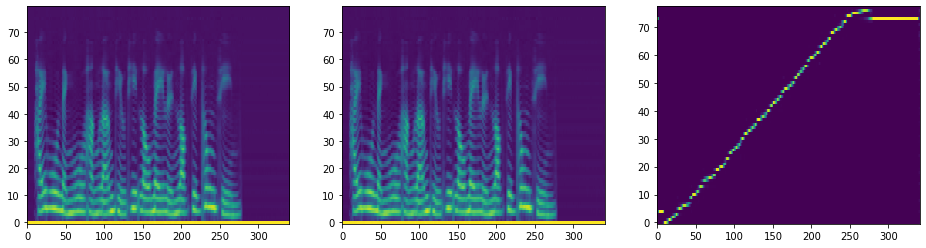

In [20]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [26]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

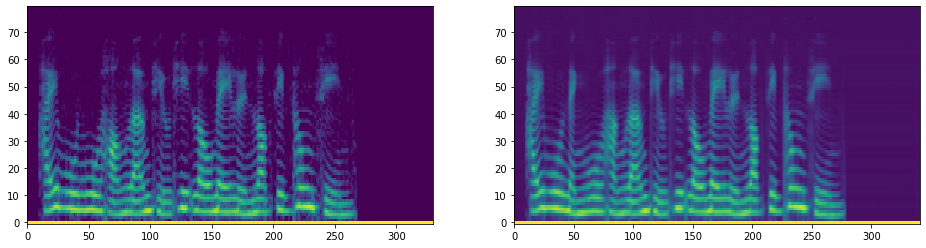

In [21]:
# target mel spectrogram vs predicted spectrogram
plot_data([mel, mel_outputs_postnet.float().data.cpu().numpy()[0]])

In [22]:
# explore data
ipd.Audio(text_mel_loader.audiopaths_and_text[0][0])

### WaveGlow

In [27]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
#     audio = waveglow.infer(mel.unsqueeze(0).cuda().half(), sigma=0.666)
    
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

/home/lokhiufung/miniconda3/envs/pytorch-1.3/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/lokhiufung/miniconda3/envs/pytorch-1.3/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/lokhiufung/miniconda3/envs/pytorch-1.3/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/lokhiufung/miniconda3/envs/pytorch-1.3/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use t

### Griffin-Lim 

from: https://github.com/NVIDIA/tacotron2/issues/201

In [36]:
griffin_iters = 60
# mel.unsqueeze(0).cuda()
taco_stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, sampling_rate=hparams.sampling_rate)
mel_decompress = taco_stft.spectral_de_normalize(mel_outputs_postnet)
mel_decompress = mel_decompress.transpose(1, 2).data.cpu()
spec_from_mel_scaling = 1000
spec_from_mel = torch.mm(mel_decompress[0], taco_stft.mel_basis)
spec_from_mel = spec_from_mel.transpose(0, 1).unsqueeze(0)
spec_from_mel = spec_from_mel * spec_from_mel_scaling

audio = griffin_lim(torch.autograd.Variable(spec_from_mel[:, :, :-1]), taco_stft.stft_fn, griffin_iters)

audio = audio.squeeze()
audio = audio.cpu().numpy()

In [37]:
print(mel_outputs_postnet)

tensor([[[-5.0916, -5.2690, -5.4737,  ..., -2.2262, -1.5444, -0.8579],
         [-4.5913, -4.4238, -4.4280,  ..., -1.3722, -0.5706, -0.0893],
         [-4.3154, -4.0352, -3.9349,  ..., -1.0615, -0.0906,  0.2322],
         ...,
         [-8.1945, -8.1383, -8.0656,  ..., -4.0523, -4.6587, -4.8380],
         [-8.2555, -8.1995, -8.1368,  ..., -4.3356, -4.8455, -5.0076],
         [-8.2487, -8.1718, -8.0584,  ..., -4.5560, -5.1133, -5.1680]]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [38]:
from scipy.io.wavfile import write
write('test.wav', hparams.sampling_rate, audio)